# lab6

In [5]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [6]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 - Population Growth Rate

option A: do the calculation with SQL

In [7]:
q1_sql = """
SELECT 
    year,
    pop,
    ROUND(
        (pop - LAG(pop) OVER (ORDER BY year)) * 100.0 / LAG(pop) OVER (ORDER BY year),
        2
    ) AS yoy_growth_rate
FROM 
    population
WHERE 
    fips = '20'  -- Kansas FIPS code
ORDER BY 
    year;
    """

In [8]:
import pandas as pd

q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head() #show the top 5 rows

/tmp/ipykernel_7438/2656640038.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,year,pop,yoy_growth_rate
0,2005,2662616,NaN
1,2006,2764075,3.81
2,2007,2775997,0.43
3,2008,2802134,0.94
4,2009,2818747,0.59


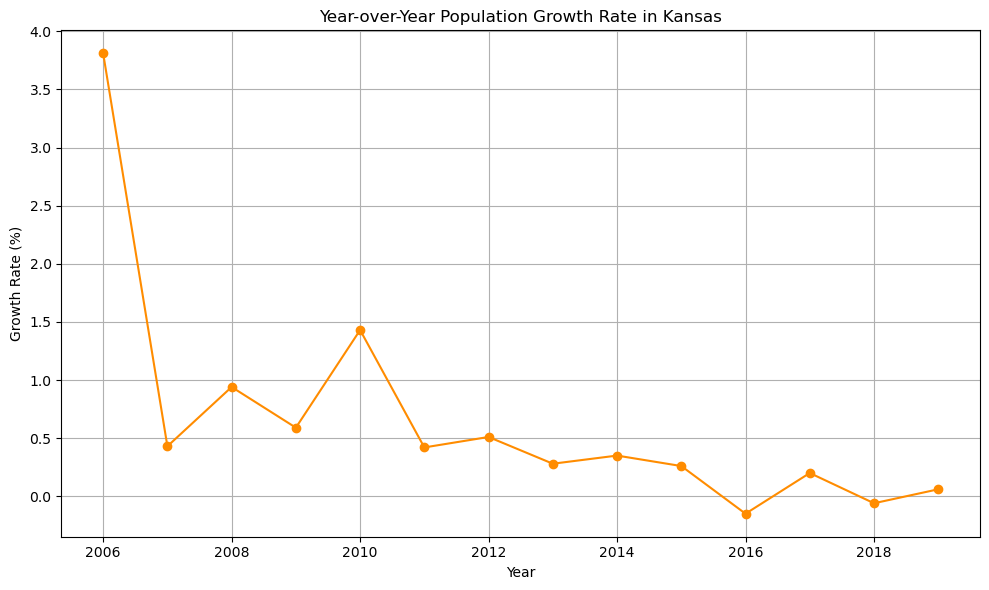

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(q1_df['year'], q1_df['yoy_growth_rate'], marker='o', linestyle='-', color='darkorange')
plt.title('Year-over-Year Population Growth Rate in Kansas')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

## The graph shown above displays the year-over-year growth rate in Kansas. In 2006, its growth rate begins at an all time high around 3.8% and then instantly pluments to 0.5% in 2007. afterwards it goes up and down and ultimately keeps decreasing from 2010 to 2018.

## Q2: Income and Population Relationship in Kansas

In [10]:
q2_sql = """
SELECT 
    p.year,
    p.pop,
    i.income
FROM 
    population p
JOIN 
    income i
ON 
    p.fips = i.fips AND p.year = i.year
WHERE 
    p.fips = '20'  -- Kansas FIPS code
ORDER BY 
    p.year;
"""

In [11]:
import pandas as pd

q2_df = pd.read_sql(q2_sql, con=conn)
q2_df.head()

/tmp/ipykernel_7438/33732788.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(q2_sql, con=conn)


,year,pop,income
0,2005,2662616,42920
1,2006,2764075,45478
2,2007,2775997,47451
3,2008,2802134,50177
4,2009,2818747,47817


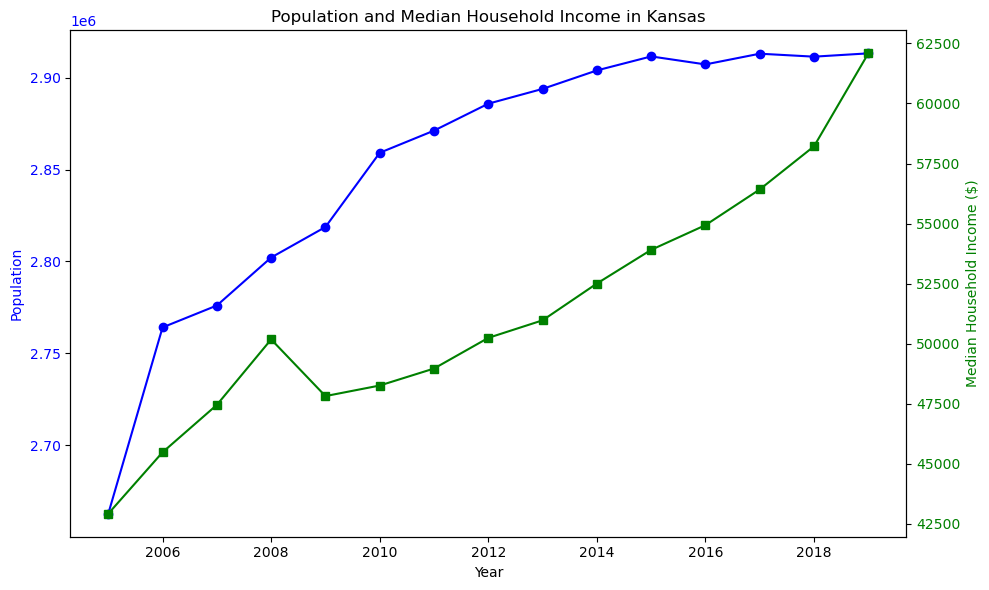

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left Y-axis: Population
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='blue')
ax1.plot(q2_df['year'], q2_df['pop'], color='blue', marker='o', label='Population')
ax1.tick_params(axis='y', labelcolor='blue')

# Right Y-axis: Income
ax2 = ax1.twinx()
ax2.set_ylabel('Median Household Income ($)', color='green')
ax2.plot(q2_df['year'], q2_df['income'], color='green', marker='s', label='Income')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Population and Median Household Income in Kansas')
fig.tight_layout()
plt.show()

## This chart compares Kansas's population and median household income over time. While population shows steady growth, income trends may reflect economic cycles, wage changes, or inflation. If both metrics rise together, it suggests economic expansion. Divergence between the two may indicate disparities in growth or shifts in cost of living.

## Q3: Student-Defined Question — Largest Population Increase Year

In [16]:
q3_sql = """
SELECT 
    year,
    pop,
    (pop - LAG(pop) OVER (ORDER BY year)) AS pop_change
FROM 
    population
WHERE 
    fips = '20'  -- Kansas
ORDER BY 
    pop_change DESC

"""

In [17]:
import pandas as pd

q3_df = pd.read_sql(q3_sql, con=conn)
q3_df.head()

/tmp/ipykernel_7438/1797757625.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q3_df = pd.read_sql(q3_sql, con=conn)


,year,pop,pop_change
0,2005,2662616,NaN
1,2006,2764075,101459.0
2,2010,2859169,40422.0
3,2008,2802134,26137.0
4,2009,2818747,16613.0


/tmp/ipykernel_7438/2447033967.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q3_chart_df = pd.read_sql(q3_chart_sql, con=conn)


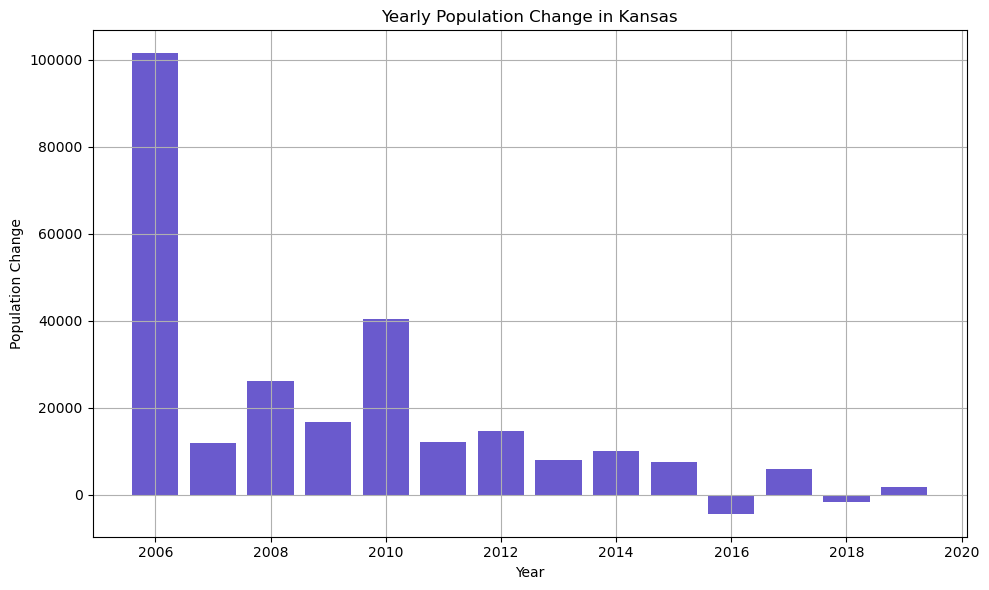

In [18]:
q3_chart_sql = """
SELECT 
    year,
    (pop - LAG(pop) OVER (ORDER BY year)) AS pop_change
FROM 
    population
WHERE 
    fips = '20'
ORDER BY 
    year;
"""

q3_chart_df = pd.read_sql(q3_chart_sql, con=conn)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(q3_chart_df['year'], q3_chart_df['pop_change'], color='slateblue')
plt.title('Yearly Population Change in Kansas')
plt.xlabel('Year')
plt.ylabel('Population Change')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
The year with the largest population increase in Kansas was [YEAR], with a change of [VALUE] people. This spike may reflect economic growth, migration, or other demographic shifts. The bar chart shows how population change varies year to year, highlighting periods of rapid growth or stagnation.